In [132]:
!pip install scikit-plot
!pip install kaggle
!pip install kagglehub --upgrade
!pip install imbalanced-learn


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



   ---------------------------------------- 0/2 [sklearn-compat]
   ---------------------------------------- 0/2 [sklearn-compat]
   ---------------------------------------- 0/2 [sklearn-compat]
   ---------------------------------------- 0/2 [sklearn-compat]
   ---------------------------------------- 0/2 [sklearn-compat]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# REGRESSION MODEL

#### Import Libraries

In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.linear_model import LinearRegression
import scikitplot as skplt
from scipy.stats import skew
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#### Import Data - Public Funding and Donations to UK Political Parties (Regression)

https://www.kaggle.com/datasets/thedevastator/donations-accepted-by-political-parties-in-the-u



In [214]:
# Path to your CSV file
csv_path = r"C:\Users\MSI\OneDrive\1. BiG_dAtA_Master_Degree\thesis\Code\Data\Regression\Donations accepted by political parties.csv"

# Load the CSV
data = pd.read_csv(csv_path)

C:\Users\MSI\AppData\Local\Temp\ipykernel_11104\367354798.py:5: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(csv_path)


In [215]:
print("\nColumn Names:")
print(data.columns)


Column Names:
Index(['index', 'ECRef', 'RegulatedEntityName', 'RegulatedEntityType', 'Value',
       'AcceptedDate', 'AccountingUnitName', 'DonorName',
       'AccountingUnitsAsCentralParty', 'IsSponsorship', 'DonorStatus',
       'RegulatedDoneeType', 'CompanyRegistrationNumber', 'Postcode',
       'DonationType', 'NatureOfDonation', 'PurposeOfVisit', 'DonationAction',
       'ReceivedDate', 'ReportedDate', 'IsReportedPrePoll',
       'ReportingPeriodName', 'IsBequest', 'IsAggregation',
       'RegulatedEntityId', 'AccountingUnitId', 'DonorId', 'CampaigningName',
       'RegisterName', 'IsIrishSource'],
      dtype='object')


#### Dataset Variables Description

| Variable | Description | Type |
|----------|-------------|------|
| ECRef | Electoral Commission Reference | String |
| RegulatedEntityName | Political party receiving donation | String |
| RegulatedEntityType | Type of political party | String |
| Value | Amount donated | Float |
| AcceptedDate | Date accepted | Date |
| AccountingUnitName | Accounting unit name | String |
| DonorName | Name of donor | String |
| AccountingUnitsAsCentralParty | Registered as central party? | Boolean |
| IsSponsorship | Is sponsorship? | Boolean |
| DonorStatus | Donor status | String |
| RegulatedDoneeType | Donee type | String |
| CompanyRegistrationNumber | Company registration number | String |
| Postcode | Donor postcode | String |
| DonationType | Type of donation | String |
| NatureOfDonation | Nature of donation | String |
| PurposeOfVisit | Purpose of visit | String |
| DonationAction | Donation action | String |
| ReceivedDate | Date received | Date |
| ReportedDate | Date reported | Date |
| IsReportedPrePoll | Reported before poll? | Boolean |


In [216]:
data.head()

,index,ECRef,RegulatedEntityName,RegulatedEntityType,Value,AcceptedDate,AccountingUnitName,DonorName,AccountingUnitsAsCentralParty,IsSponsorship,...,IsReportedPrePoll,ReportingPeriodName,IsBequest,IsAggregation,RegulatedEntityId,AccountingUnitId,DonorId,CampaigningName,RegisterName,IsIrishSource
0,0,NC0408174,Mr Andy Street,Regulated Donee,"£1,876.56",02/09/2019,NaN,Conservative and Unionist Party,False,False,...,NaN,September 2019,False,False,8015,NaN,86310.0,NaN,Great Britain,False
1,1,NC0408173,Mr Andy Street,Regulated Donee,"£2,700.00",02/09/2019,NaN,Conservative and Unionist Party,False,False,...,NaN,September 2019,False,False,8015,NaN,86310.0,NaN,Great Britain,False
2,2,NC0408177,Mr Andy Street,Regulated Donee,"£4,852.58",30/08/2019,NaN,Conservative and Unionist Party,False,False,...,NaN,September 2019,False,False,8015,NaN,86310.0,NaN,Great Britain,False
3,3,NC0408176,Mr Andy Street,Regulated Donee,"£2,500.00",30/08/2019,NaN,Conservative and Unionist Party,False,False,...,NaN,September 2019,False,False,8015,NaN,86310.0,NaN,Great Britain,False
4,4,NC0408170,Mr Andy Street,Regulated Donee,"£4,524.05",29/08/2019,NaN,Conservative and Unionist Party,False,False,...,NaN,September 2019,False,False,8015,NaN,86310.0,NaN,Great Britain,False


### EXPLORATION AND CLEANING DATA

#### Summary of Excluded Columns

- **Identifiers**: `index`, `ECRef`, `RegulatedEntityId`, `AccountingUnitId`, `DonorId` – No predictive value, only unique identifiers.
- **High Missing Rate**: `RegulatedDoneeType` (~89%), `CompanyRegistrationNumber` (~82%), `NatureOfDonation` (~85%), `PurposeOfVisit` (~96%), `DonationAction` (~99.6%), `CampaigningName` (~99.99%) – Too many missing values, unusable.
- **Redundant**: `AccountingUnitName` (~13%, redundant with `RegulatedEntityName`), `ReceivedDate` (~4%, similar to `AcceptedDate`), `ReportingPeriodName` (redundant with `AcceptedDate`), `ReportedDate` (administrative) – Duplicated or irrelevant information.
- **High Cardinality**: `DonorName` (unique names), `RegulatedEntityName` (1,384 values), `Postcode` (4,559 values) – Generate excessive dummy columns, increasing complexity and risk of overfitting.
- **Low Variability**: `IsReportedPrePoll` (only `False`), `RegisterName` (~90% `Great Britain`) – Do not provide predictive information.


In [218]:
# Exploration and Data Cleaning
# Objective: Understand dataset structure, types, and missing values.
print("1. Data Exploration and Cleaning")
print("\nDataset Info:")
print(data.info())
print("\nMissing Values per Column:")
print(data.isnull().sum())

1. Data Exploration and Cleaning

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65278 entries, 0 to 65277
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   index                          65278 non-null  int64  
 1   ECRef                          65278 non-null  object 
 2   RegulatedEntityName            65278 non-null  object 
 3   RegulatedEntityType            65278 non-null  object 
 4   Value                          65278 non-null  object 
 5   AcceptedDate                   64265 non-null  object 
 6   AccountingUnitName             56957 non-null  object 
 7   DonorName                      65193 non-null  object 
 8   AccountingUnitsAsCentralParty  65278 non-null  bool   
 9   IsSponsorship                  65278 non-null  bool   
 10  DonorStatus                    65220 non-null  object 
 11  RegulatedDoneeType             7090 non-null   object 
 12

#### Variables for the model

In [219]:
# Select definitive columns
selected_columns = [
    'Value', 'RegulatedEntityType', 'DonorStatus', 'DonationType', 
    'AcceptedDate', 'IsSponsorship', 'IsBequest', 'IsAggregation', 
    'AccountingUnitsAsCentralParty', 'IsIrishSource'
    ]
data_selected = data[selected_columns].copy()  # Create independent copy
print(data_selected)

             Value    RegulatedEntityType                 DonorStatus  \
0        £1,876.56        Regulated Donee  Registered Political Party   
1        £2,700.00        Regulated Donee  Registered Political Party   
2        £4,852.58        Regulated Donee  Registered Political Party   
3        £2,500.00        Regulated Donee  Registered Political Party   
4        £4,524.05        Regulated Donee  Registered Political Party   
...            ...                    ...                         ...   
65273   £10,000.00  Permitted Participant                     Company   
65274  £100,000.00  Permitted Participant                  Individual   
65275   £40,000.00  Permitted Participant                  Individual   
65276   £50,000.00        Political Party                  Individual   
65277   £15,000.00        Political Party                  Individual   

      DonationType AcceptedDate  IsSponsorship  IsBequest  IsAggregation  \
0         Non Cash   02/09/2019          False 

#### Transform Target Variable

In [220]:
#Clean and convert 'Value'
print("\nDescriptive Statistics for Value (before cleaning):")
print(data['Value'].describe())

data_selected.loc[:, 'Value'] = data_selected['Value'].replace('[\£,]', '', regex=True)
data_selected.loc[:, 'Value'] = pd.to_numeric(data_selected['Value'], errors='coerce')
data_selected['Value'] = data_selected['Value'].astype(float)

print("NEW Dataset Info:")
print(data_selected.info())


Descriptive Statistics for Value (before cleaning):
count         65278
unique        11253
top       £2,000.00
freq           5276
Name: Value, dtype: object
NEW Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65278 entries, 0 to 65277
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Value                          65278 non-null  float64
 1   RegulatedEntityType            65278 non-null  object 
 2   DonorStatus                    65220 non-null  object 
 3   DonationType                   65278 non-null  object 
 4   AcceptedDate                   64265 non-null  object 
 5   IsSponsorship                  65278 non-null  bool   
 6   IsBequest                      65278 non-null  bool   
 7   IsAggregation                  65278 non-null  bool   
 8   AccountingUnitsAsCentralParty  65278 non-null  bool   
 9   IsIrishSource                  64557 non-null  o

#### Handle misssing values of the variables

In [222]:
#Handle missing values with MODA
cat_columns = ['RegulatedEntityType', 'DonorStatus', 'DonationType', 'IsIrishSource']
imputer_cat = SimpleImputer(strategy='most_frequent') # Imputed by MODA

data_selected.loc[:, cat_columns] = imputer_cat.fit_transform(
    data_selected[cat_columns])

# Drop rows with missing AcceptedDate
data_selected = data_selected.dropna(subset=['AcceptedDate'])

# Verification
print("Missing values after imputation:")
print(data_selected.isna().sum())

Missing values after imputation:
Value                            0
RegulatedEntityType              0
DonorStatus                      0
DonationType                     0
AcceptedDate                     0
IsSponsorship                    0
IsBequest                        0
IsAggregation                    0
AccountingUnitsAsCentralParty    0
IsIrishSource                    0
dtype: int64


#### Feature Engineer AcceptedDate

In [223]:
# Adapted function to convert text or datetime to datetime
def convert_to_datetime(value):
    if pd.isna(value):
        return pd.NaT
    if isinstance(value, pd.Timestamp) or isinstance(value, datetime):  # Preserve Timestamps or datetime
        return pd.to_datetime(value)
    if isinstance(value, str):  # Handle text dates
        try:
            # Try dd/mm/yyyy or d/m/yyyy (both handled by %d/%m/%Y)
            return pd.to_datetime(value, format='%d/%m/%Y', errors='coerce')
        except:
            return pd.NaT
    return pd.NaT

# Apply conversion
# Observation: Convert text dates to datetime, preserve Timestamps. Keep NaT for nulls/invalid dates.
data_selected.loc[:, 'AcceptedDate'] = data_selected['AcceptedDate'].apply(convert_to_datetime)
#Verify
print("NaT dates (invalid or null):", data_selected['AcceptedDate'].isna().sum())

NaT dates (invalid or null): 0


In [224]:
# Extract Year
# Convert AcceptedDate to datetime64[ns]
data_selected['AcceptedDate'] = pd.to_datetime(data_selected['AcceptedDate'], errors='coerce', dayfirst=True)
# Extract year and drop the original column
data_selected['Year'] = data_selected['AcceptedDate'].dt.year
data_selected.drop(columns='AcceptedDate', inplace=True)

# Verification
print("\nUnique values of Year (without NaN)):", sorted(data_selected['Year'].dropna().unique()))


Unique values of Year (without NaN)): [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


#### Transforming Dependent Variable

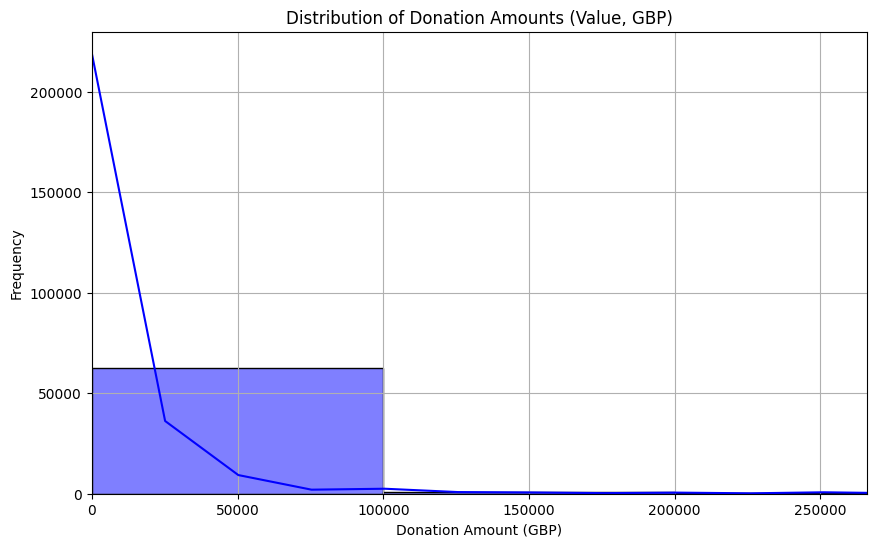

Skewness: 19.851462185463905


In [226]:
# Plot Value distribution before transformation
# Objective: Visualize long-tail distribution.
plt.figure(figsize=(10, 6))
sns.histplot(data_selected['Value'].dropna(), bins=50, kde=True, color='blue')
plt.title('Distribution of Donation Amounts (Value, GBP)')
plt.xlabel('Donation Amount (GBP)')
plt.ylabel('Frequency')
plt.xlim(0, data_selected['Value'].quantile(0.99))
plt.grid(True)
plt.show()
print("Skewness:", skew(data_selected['Value'].dropna()))

In [227]:
# Transform Value, apply log1p to reduce skewness.
if (data_selected['Value'] < 0).any():
    print("Warning: Negative values in Value. Converting to NaN.")
    data_selected.loc[data_selected['Value'] < 0, 'Value'] = np.nan
data_selected['Value'] = np.log1p(data_selected['Value'])

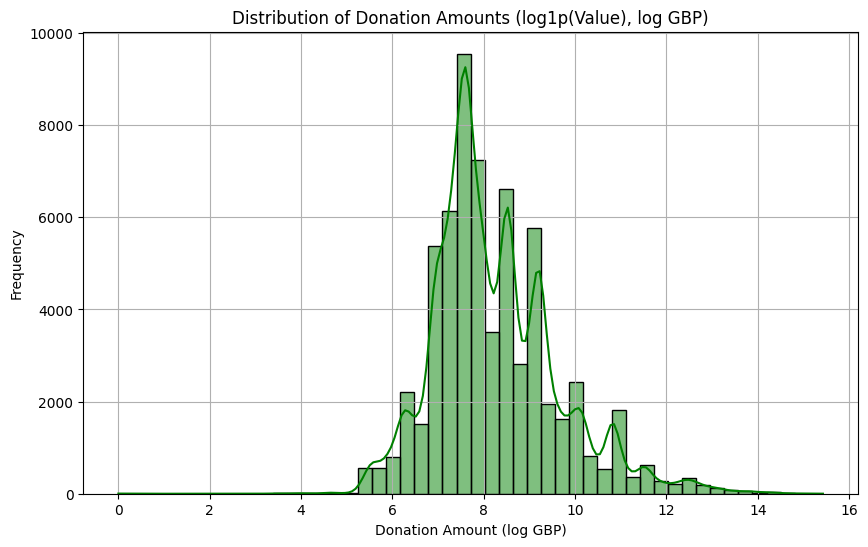

Skewness: 0.8652401300176229


In [228]:
# Plot Value distribution after transformation
# Objective: Visualize symmetric distribution.
plt.figure(figsize=(10, 6))
sns.histplot(data_selected['Value'].dropna(), bins=50, kde=True, color='green')
plt.title('Distribution of Donation Amounts (log1p(Value), log GBP)')
plt.xlabel('Donation Amount (log GBP)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
print("Skewness:", skew(data_selected['Value'].dropna()))

#### One Hot Encoding

In [229]:
# One-hot encode categorical variables
data_encoded = pd.get_dummies(data_selected, columns=cat_columns, drop_first=True)
print(data_encoded.head())

      Value  IsSponsorship  IsBequest  IsAggregation  \
0  7.537728          False      False          False   
1  7.901377          False      False          False   
2  8.487472          False      False          False   
3  7.824446          False      False          False   
4  8.417384          False      False          False   

   AccountingUnitsAsCentralParty  Year  RegulatedEntityType_Political Party  \
0                          False  2019                                False   
1                          False  2019                                False   
2                          False  2019                                False   
3                          False  2019                                False   
4                          False  2019                                False   

   RegulatedEntityType_Regulated Donee  RegulatedEntityType_Third Party  \
0                                 True                            False   
1                                 True

#### Target and Features

In [230]:
# Define features and target
X = data_encoded.drop('Value', axis=1)
y = data_encoded['Value']

#### Normalize Variables

In [231]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("\nNormalization Verification:")
print("Mean of scaled features:", X_scaled.mean(axis=0).round(4))
print("Std of scaled features:", X_scaled.std(axis=0).round(4))


Normalization Verification:
Mean of scaled features: [ 0.  0.  0. -0. -0.  0.  0. -0. -0. -0.  0.  0. -0. -0. -0.  0.  0.  0.
  0. -0.  0.  0.  0.  0.  0.]
Std of scaled features: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]


#### Split Data

In [232]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
print("Train X shape:", X_train.shape)
print("Test X shape:", X_test.shape)
print("Train y shape:", y_train.shape)
print("Test y shape:", y_test.shape)

Train X shape: (44985, 25)
Test X shape: (19280, 25)
Train y shape: (44985,)
Test y shape: (19280,)


#### Model 1

In [233]:
# Random Forest Model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

#### Regression Metrics Model 1

In [234]:
# Function to calculate Adjusted R² using len()
def adjusted_r2(r2, y_test, X_test):
    n = len(y_test)  # Number of observations
    p = len(X_test[0])  # Number of predictors
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)


In [235]:
# Random Forest Metrics
# Mean Squared Error (MSE): 
rf_mse = mean_squared_error(y_test, rf_pred)
# Root Mean Squared Error (RMSE): 
rf_rmse = np.sqrt(rf_mse)
# Root Mean Squared Logarithmic Error (RMSLE):
rf_rmsle = rf_rmse  # RMSLE = RMSE since y is log-transformed
# Mean Absolute Error (MAE):
rf_mae = mean_absolute_error(y_test, rf_pred)
# R-squared (R²):
rf_r2 = r2_score(y_test, rf_pred)  # Aligned with kulkarni-vishwanath
# Adjusted R-squared (R²_adj): 
rf_r2_adj = adjusted_r2(rf_r2, y_test, X_test)
# Mean Absolute Percentage Error (MAPE):
rf_mape = np.nanmean(np.abs((y_test - rf_pred) / np.where(y_test != 0, y_test, np.nan))) * 100

In [236]:
print("\nRandom Forest Metrics:")
print(f"Mean Squared Error (MSE): {rf_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rf_rmse:.4f}")
print(f"Root Mean Squared Logarithmic Error (RMSLE): {rf_rmsle:.4f}")
print(f"Mean Absolute Error (MAE): {rf_mae:.4f}")
print(f"R-squared (R²): {rf_r2:.4f}")
print(f"Adjusted R-squared (R²_adj): {rf_r2_adj:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {rf_mape:.4f}")


Random Forest Metrics:
Mean Squared Error (MSE): 1.1889
Root Mean Squared Error (RMSE): 1.0904
Root Mean Squared Logarithmic Error (RMSLE): 1.0904
Mean Absolute Error (MAE): 0.8122
R-squared (R²): 0.3712
Adjusted R-squared (R²_adj): 0.3704
Mean Absolute Percentage Error (MAPE): 9.5775


#### Model 2

In [237]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

#### Regression Metrics Model 2

In [238]:
# Linear Regression Metrics
lr_mse = mean_squared_error(y_test, lr_pred)
lr_rmse = np.sqrt(lr_mse)
lr_rmsle = lr_rmse
lr_mae = mean_absolute_error(y_test, lr_pred)
lr_r2 = r2_score(y_test, lr_pred)
lr_r2_adj = adjusted_r2(lr_r2, y_test, X_test)
lr_mape = np.nanmean(np.abs((y_test - lr_pred) / np.where(y_test != 0, y_test, np.nan))) * 100

print("\nLinear Regression Metrics:")
print(f"Mean Squared Error (MSE): {lr_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {lr_rmse:.4f}")
print(f"Root Mean Squared Logarithmic Error (RMSLE): {lr_rmsle:.4f}")
print(f"Mean Absolute Error (MAE): {lr_mae:.4f}")
print(f"R-squared (R²): {lr_r2:.4f}")
print(f"Adjusted R-squared (R²_adj): {lr_r2_adj:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {lr_mape:.4f}")



Linear Regression Metrics:
Mean Squared Error (MSE): 1.2873
Root Mean Squared Error (RMSE): 1.1346
Root Mean Squared Logarithmic Error (RMSLE): 1.1346
Mean Absolute Error (MAE): 0.8662
R-squared (R²): 0.3192
Adjusted R-squared (R²_adj): 0.3183
Mean Absolute Percentage Error (MAPE): 10.2989


In [240]:
# Step 4.3: Compare Models
print("\nModel Comparison:")

metrics_df = pd.DataFrame({
    'Linear Regression': {
        'Mean Squared Error (MSE)': lr_mse,
        'Root Mean Squared Error (RMSE)': lr_rmse,
        'Root Mean Squared Logarithmic Error (RMSLE)': lr_rmsle,
        'Mean Absolute Error (MAE)': lr_mae,
        'R-squared (R²)': lr_r2,
        'Adjusted R-squared (R²_adj)': lr_r2_adj,
        'Mean Absolute Percentage Error (MAPE)': lr_mape
    },
    'Random Forest': {
        'Mean Squared Error (MSE)': rf_mse,
        'Root Mean Squared Error (RMSE)': rf_rmse,
        'Root Mean Squared Logarithmic Error (RMSLE)': rf_rmsle,
        'Mean Absolute Error (MAE)': rf_mae,
        'R-squared (R²)': rf_r2,
        'Adjusted R-squared (R²_adj)': rf_r2_adj,
        'Mean Absolute Percentage Error (MAPE)': rf_mape
    }
})

# Optional: round for cleaner display
metrics_df = metrics_df.round(4)

# Show the DataFrame
display(metrics_df)


Model Comparison:


,Linear Regression,Random Forest
Mean Squared Error (MSE),1.2873,1.1889
Root Mean Squared Error (RMSE),1.1346,1.0904
Root Mean Squared Logarithmic Error (RMSLE),1.1346,1.0904
Mean Absolute Error (MAE),0.8662,0.8122
R-squared (R²),0.3192,0.3712
Adjusted R-squared (R²_adj),0.3183,0.3704
Mean Absolute Percentage Error (MAPE),10.2989,9.5775


# CLASSIFICATION MODEL

IMPORT DATA - Non-Profit Funding in the EU (Classification)

https://www.kaggle.com/datasets/sarmitamajumdar/finding-donors-for-a-charity/data

#### Import Libraries

In [242]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, power_transform
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time

#### Load the dataset

In [179]:
# Load dataset
file_path = r"C:\Users\MSI\OneDrive\1. BiG_dAtA_Master_Degree\thesis\Code\Data\Classification\census.csv"
df_charity = pd.read_csv(file_path)

In [180]:
print("\nColumn Names:")
print(df_charity.columns)


Column Names:
Index(['age', 'workclass', 'education_level', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')


In [181]:
df_charity.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


### EXPLORATION AND CLEANING DATA

In [182]:
print("\nDataset Info:")
print(df_charity.info())
print("\nMissing Values:")
print(df_charity.isnull().sum())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              45222 non-null  int64  
 1   workclass        45222 non-null  object 
 2   education_level  45222 non-null  object 
 3   education-num    45222 non-null  float64
 4   marital-status   45222 non-null  object 
 5   occupation       45222 non-null  object 
 6   relationship     45222 non-null  object 
 7   race             45222 non-null  object 
 8   sex              45222 non-null  object 
 9   capital-gain     45222 non-null  float64
 10  capital-loss     45222 non-null  float64
 11  hours-per-week   45222 non-null  float64
 12  native-country   45222 non-null  object 
 13  income           45222 non-null  object 
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB
None

Missing Values:
age                0
workclass          0
education_leve

#### Variables for the model

In [183]:
# Select relevant columns
numerical_cols = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_cols = ['workclass', 'education_level', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
target_col = 'income'
df_selected = df_charity[numerical_cols + categorical_cols + [target_col]]

#### Transform Traget Variables

In [184]:
# Convert target to binary (1 for '>50K', 0 for '≤50K')
df_charity['income'] = df_charity['income'].str.strip().map({'>50K': 1, '<=50K': 0})

# Verify target conversion
before_dist = y.value_counts(normalize=True)
print(before_dist)

income
<=50K    0.752156
>50K     0.247844
Name: proportion, dtype: float64


#### 📊 Income Distribution:
- **75.2%** of the observations have income ≤50K (**class 0**)  
- **24.8%** of the observations have income >50K (**class 1**) 

**____Unbalanced**

#### Transform Numeric Variables

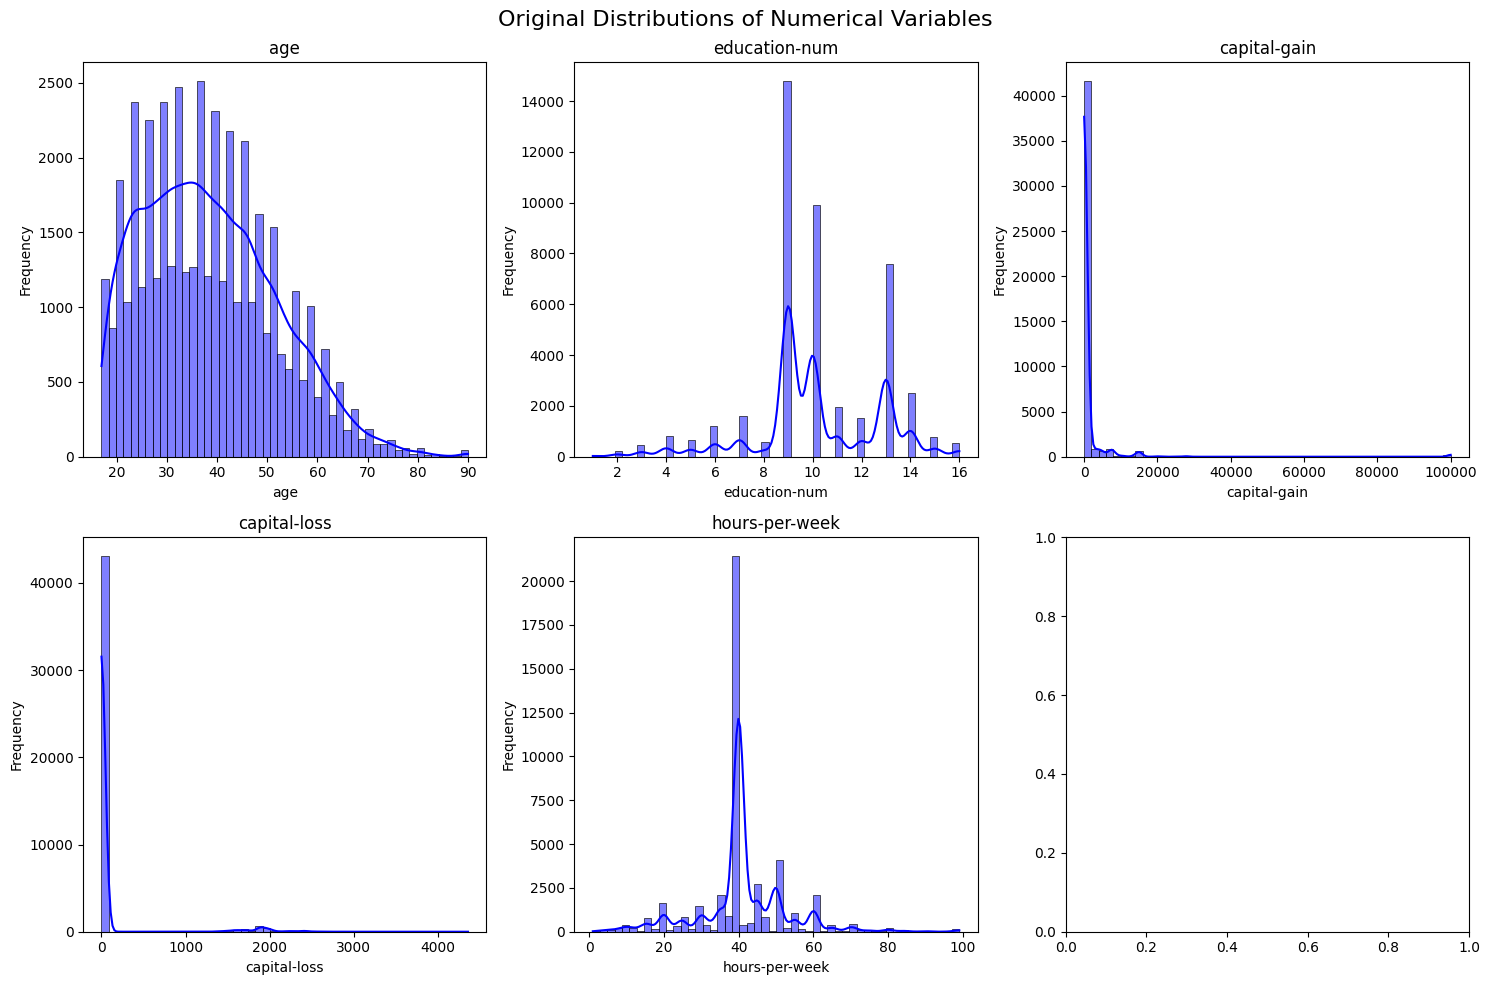

Skewness values:
age: 0.53
education-num: -0.31
capital-gain: 11.79
capital-loss: 4.52
hours-per-week: 0.34


In [185]:
# Visualize original distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Original Distributions of Numerical Variables', fontsize=16)

for i, col in enumerate(numerical_cols):
    row = i // 3
    col_idx = i % 3
    sns.histplot(data=df_charity, x=col, bins=50, kde=True, ax=axes[row, col_idx], color='blue')
    axes[row, col_idx].set_title(col)
    axes[row, col_idx].set_xlabel(col)
    axes[row, col_idx].set_ylabel('Frequency')

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

# Print skewness values
print("Skewness values:")
for col in numerical_cols:
    skew_val = skew(df_charity[col].dropna())
    print(f"{col}: {skew_val:.2f}")

### 📈 Skewness (Asymmetry of the Distribution)

- **|Skewness| < 0.5**: Approximately symmetric distribution.  
- **|Skewness| between 0.5 and 1**: Moderately skewed distribution.  
- **|Skewness| > 1**: Highly skewed distribution, may benefit from transformation.  

**Interpretation of the sign:**  
- **Positive skewness** ➝ skewed to the **right** (long tail to the right).  
- **Negative skewness** ➝ skewed to the **left** (long tail to the left).

##### Transform Distributions to Reduce Skewness

In [187]:
# Create indicator columns for zeros - (1 si es cero, 0 si no).
df_charity['capital-gain-zero'] = (df_charity['capital-gain'] == 0).astype(int)
df_charity['capital-loss-zero'] = (df_charity['capital-loss'] == 0).astype(int)

# Cap outliers at 98th percentile for non-zero values
for col in ['capital-gain', 'capital-loss']:
    non_zero_mask = df_charity[col] > 0
    percentile_98 = df_charity.loc[non_zero_mask, col].quantile(0.98)
    df_charity.loc[non_zero_mask, col] = np.where(df_charity.loc[non_zero_mask, col] > percentile_98, percentile_98, df_charity.loc[non_zero_mask, col])

# Replace zeros with NaN and transform non-zero values with Yeo-Johnson - reemplazas los ceros por NaN para no incluirlos en la transformación,
df_transformed = df_charity[numerical_cols].copy()
for col in ['capital-gain', 'capital-loss']:
    df_transformed[col] = df_transformed[col].replace(0, np.nan)
    non_zero_mask = df_transformed[col].notna()
    non_zero_values = df_transformed.loc[non_zero_mask, col].values.reshape(-1, 1)
    transformed_values = power_transform(non_zero_values, method='yeo-johnson', standardize=False)
    df_transformed.loc[non_zero_mask, col] = transformed_values.flatten()

# Apply Yeo-Johnson to other numerical columns
other_cols = ['age', 'education-num', 'hours-per-week']
df_transformed[other_cols] = power_transform(df_transformed[other_cols], method='yeo-johnson', standardize=False)


<div style="font-size: small; line-height: 1.2;">

### Initial Problem:

- **capital-gain** and **capital-loss**: High skewness (>4–11), with ~90% zeros and extreme values (max 99,999 and 4,356).  
- **age**, **education-num**, **hours-per-week**: Slightly skewed or nearly symmetric (skewness < 0.5).

### Process:

#### Evaluation:
- Histograms confirmed heavy skewness in capital-gain and capital-loss.

#### Initial Transformations:
- `np.log1p`: Reduced skewness (capital-gain: from 11.789 to ~3, capital-loss: from 4.516 to ~4), but still not ideal (skewness > 1).  
- **Yeo-Johnson**:  
  - Improved:
    - age: from 0.533 to -0.016  
    - education-num: from -0.311 to 0.025  
    - hours-per-week: from 0.341 to 0.239  
  - Still skewed:
    - capital-gain: ~3  
    - capital-loss: ~4

#### Zero Handling:
- Zeros treated as separate binary indicators: `capital-gain-zero`, `capital-loss-zero`.  
- Yeo-Johnson applied only to non-zero values; zeros imputed with the mean for visualization purposes.

#### Outlier Capping:
- Non-zero values capped at the 98th percentile to reduce the influence of long tails.

### Final Result:

- **capital-gain**: Skewness -0.275 (nearly symmetric).  
- **capital-loss**: Skewness 0.688 (slightly skewed, acceptable).  
- **age**, **education-num**, **hours-per-week**: Skewness

In [188]:
# Impute NaN with mean of transformed non-zero values
for col in ['capital-gain', 'capital-loss']:
    mean_non_zero = df_transformed.loc[df_transformed[col].notna(), col].mean()
    df_transformed[col] = df_transformed[col].fillna(mean_non_zero)

In [189]:
# Standardize all numerical columns
scaler = StandardScaler()
df_transformed[numerical_cols] = scaler.fit_transform(df_transformed[numerical_cols])

# Update original dataframe
df_charity[numerical_cols] = df_transformed[numerical_cols]

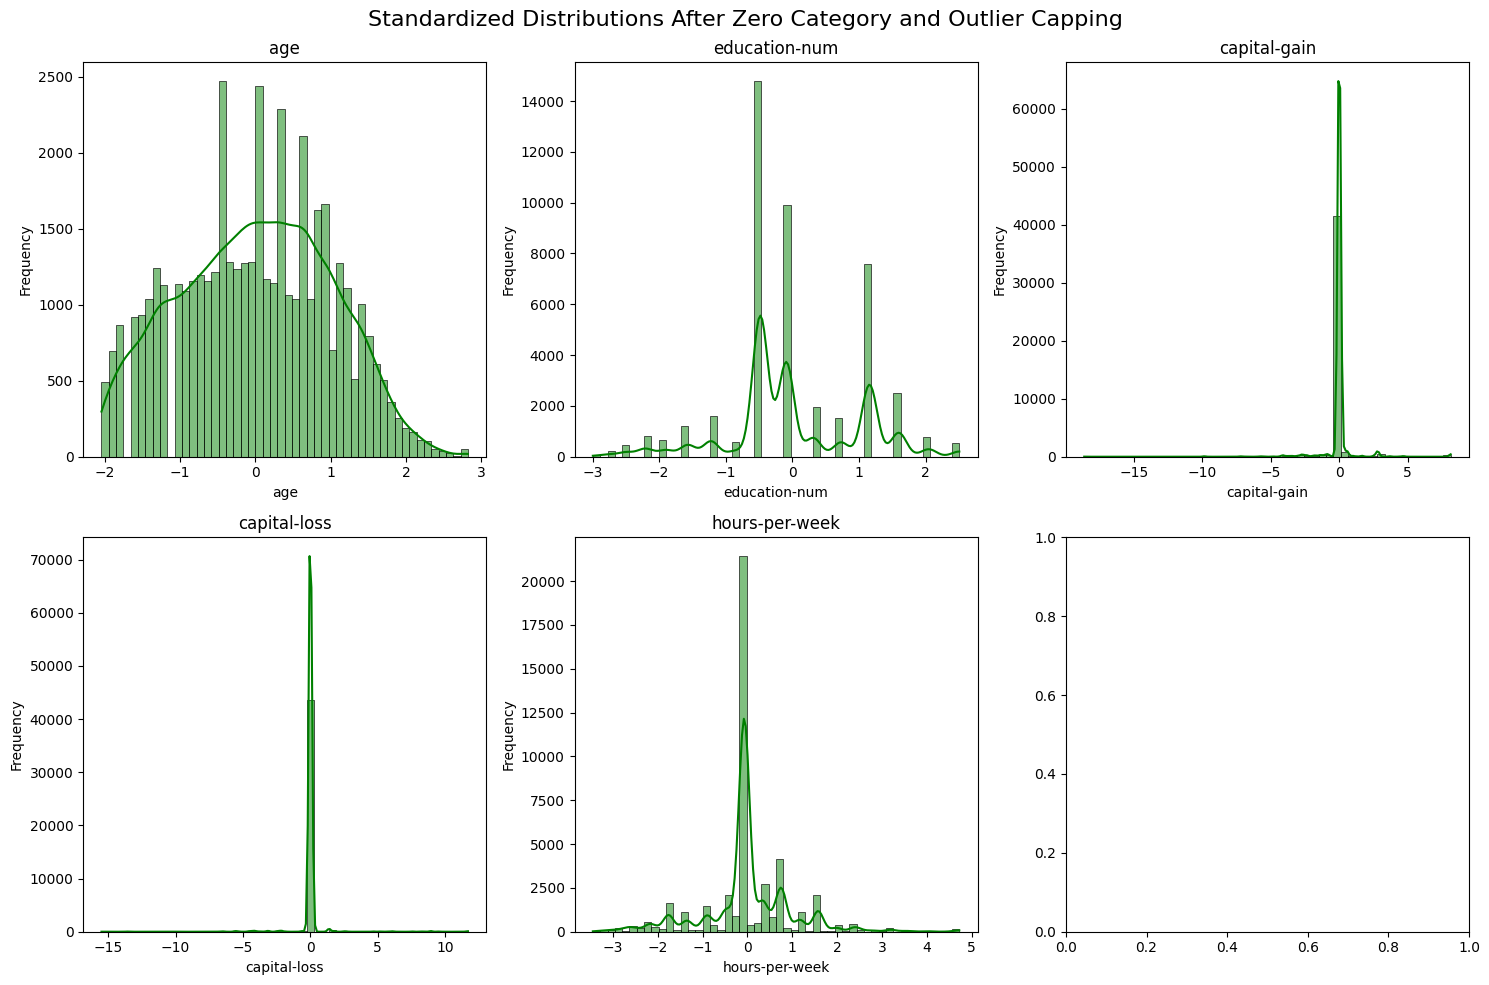


Skewness After Zero Category, Outlier Capping, and Standardization:
age: -0.016
education-num: 0.025
capital-gain: -0.275
capital-loss: 0.688
hours-per-week: 0.239


In [190]:
# Visualize standardized distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Standardized Distributions After Zero Category and Outlier Capping', fontsize=16)

for i, col in enumerate(numerical_cols):
    row = i // 3
    col_idx = i % 3
    sns.histplot(data=df_charity, x=col, bins=50, kde=True, ax=axes[row, col_idx], color='green')
    axes[row, col_idx].set_title(col)
    axes[row, col_idx].set_xlabel(col)
    axes[row, col_idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Display skewness values
print("\nSkewness After Zero Category, Outlier Capping, and Standardization:")
for col in numerical_cols:
    skewness = pd.Series(df_charity[col]).skew()
    print(f"{col}: {skewness:.3f}")

#### One Hot Encoding

In [191]:
# Encode categorical variables
df_encoded = pd.get_dummies(df_charity, columns=categorical_cols, drop_first=True)

#### Target and Features

In [192]:
# Prepare features and target
X = df_encoded.drop('income', axis=1)
y = df_encoded['income']

#### SMOTE (Synthetic Minority Oversampling Technique)

In [193]:
# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
print("\nClass Distribution After SMOTE:")
after_dist = pd.Series(y_resampled).value_counts(normalize=True)
print(after_dist)


Class Distribution After SMOTE:
income
0    0.5
1    0.5
Name: proportion, dtype: float64


#### Split Data

In [194]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42)
print("Train X shape:", X_train.shape)
print("Test X shape:", X_test.shape)
print("Train y shape:", y_train.shape)
print("Test y shape:", y_test.shape)

Train X shape: (54422, 97)
Test X shape: (13606, 97)
Train y shape: (54422,)
Test y shape: (13606,)


#### Model 1

In [195]:
# Train Random Forest Model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

#### Classification Meterics Model 1
Confusion Matrix

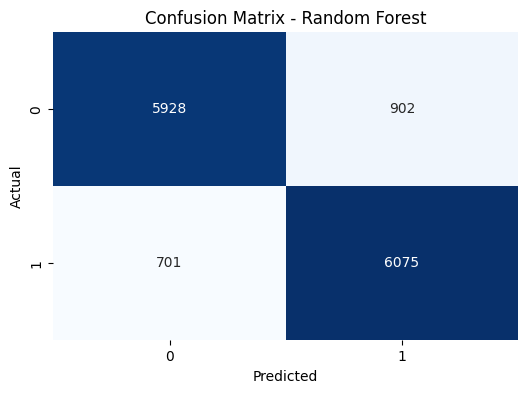

In [196]:
# Plot Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix_rf.png')
plt.show()

In [199]:
# Calculate Metrics
# Confusion Matrix elements
tn, fp, fn, tp = cm_rf.ravel()

# Metrics
rf_metrics = {
    'Accuracy Score': accuracy_score(y_test, y_pred_rf),
    'Error / Misclassification Rate': 1 - accuracy_score(y_test, y_pred_rf),
    'Sensitivity / True Positive Rate / Recall': recall_score(y_test, y_pred_rf),
    'False Positive Rate': fp / (fp + tn),
    'True Negative Rate / Specificity': tn / (tn + fp),
    'Precision': precision_score(y_test, y_pred_rf),
    'F1 Score': f1_score(y_test, y_pred_rf),
    'Log Loss': log_loss(y_test, y_prob_rf),
    'Area under the ROC Curve': roc_auc_score(y_test, y_prob_rf)
}

# Display Metrics
print("\nRandom Forest Metrics:")
for metric, value in rf_metrics.items():
    print(f"{metric}: {value:.3f}")



Random Forest Metrics:
Accuracy Score: 0.882
Error / Misclassification Rate: 0.118
Sensitivity / True Positive Rate / Recall: 0.897
False Positive Rate: 0.132
True Negative Rate / Specificity: 0.868
Precision: 0.871
F1 Score: 0.883
Log Loss: 0.445
Area under the ROC Curve: 0.947


#### Model 2

In [202]:
# Train and Evaluate Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
y_prob_lr = lr_model.predict_proba(X_test)[:, 1]

#### Classification Meterics Model 2
Confusion Matrix

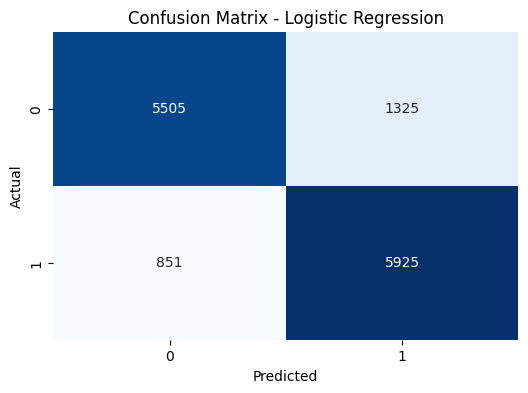

In [203]:
# Confusion Matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix_lr.png')
plt.show()

In [204]:
# Metrics for Logistic Regression
tn_lr, fp_lr, fn_lr, tp_lr = cm_lr.ravel()
lr_metrics = {
    'Accuracy Score': accuracy_score(y_test, y_pred_lr),
    'Error / Misclassification Rate': 1 - accuracy_score(y_test, y_pred_lr),
    'Sensitivity / True Positive Rate / Recall': recall_score(y_test, y_pred_lr),
    'False Positive Rate': fp_lr / (fp_lr + tn_lr),
    'True Negative Rate / Specificity': tn_lr / (tn_lr + fp_lr),
    'Precision': precision_score(y_test, y_pred_lr),
    'F1 Score': f1_score(y_test, y_pred_lr),
    'Log Loss': log_loss(y_test, y_prob_lr),
    'Area under the ROC Curve': roc_auc_score(y_test, y_prob_lr)
}
print("\nLogistic Regression Metrics:")
for metric, value in lr_metrics.items():
    print(f"{metric}: {value:.3f}")



Logistic Regression Metrics:
Accuracy Score: 0.840
Error / Misclassification Rate: 0.160
Sensitivity / True Positive Rate / Recall: 0.874
False Positive Rate: 0.194
True Negative Rate / Specificity: 0.806
Precision: 0.817
F1 Score: 0.845
Log Loss: 0.338
Area under the ROC Curve: 0.927


In [206]:
# Compare Models
print("\nModel Comparison:")
metrics_df = pd.DataFrame({'Logistic Regression': lr_metrics, 'Random Forest': rf_metrics})
print(metrics_df)


Model Comparison:
                                           Logistic Regression  Random Forest
Accuracy Score                                        0.840071       0.882184
Error / Misclassification Rate                        0.159929       0.117816
Sensitivity / True Positive Rate / Recall             0.874410       0.896547
False Positive Rate                                   0.193997       0.132064
True Negative Rate / Specificity                      0.806003       0.867936
Precision                                             0.817241       0.870718
F1 Score                                              0.844860       0.883444
Log Loss                                              0.337553       0.444608
Area under the ROC Curve                              0.927332       0.946695


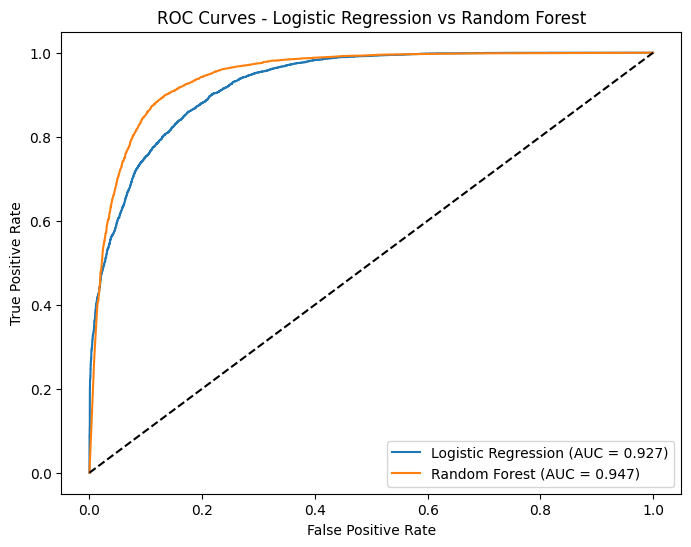

In [208]:
# Plot ROC Curves for Both Models
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {lr_metrics["Area under the ROC Curve"]:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_metrics["Area under the ROC Curve"]:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Logistic Regression vs Random Forest')
plt.legend(loc='best')
plt.savefig('roc_curves_comparison.png')
plt.show()

Step 4: Both Models Comparison and Evaluation with Fixed Performance Graph

Unique values in 'income' before conversion: ['<=50K' '>50K']

Income Distribution (After Conversion):
income
0    0.752156
1    0.247844
Name: proportion, dtype: float64

Unique values in y_train: {0, 1}
Unique values in y_test: {0, 1}

Random Forest Results:
Unique values in y_pred_rf: {0, 1}


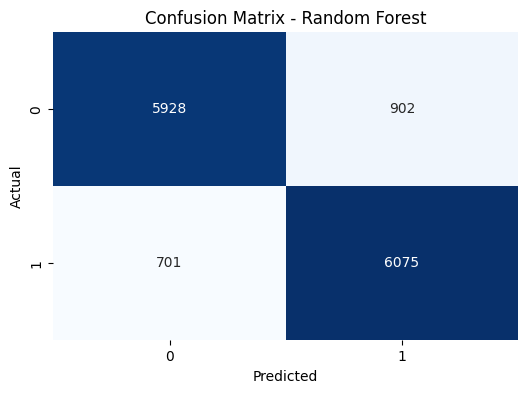


Random Forest Metrics:
Accuracy Score: 0.882
Error / Misclassification Rate: 0.118
Sensitivity / True Positive Rate / Recall: 0.897
False Positive Rate: 0.132
True Negative Rate / Specificity: 0.868
Precision: 0.871
F1 Score: 0.883
Log Loss: 0.445
Area under the ROC Curve: 0.947

Logistic Regression Results:
Unique values in y_pred_lr: {0, 1}


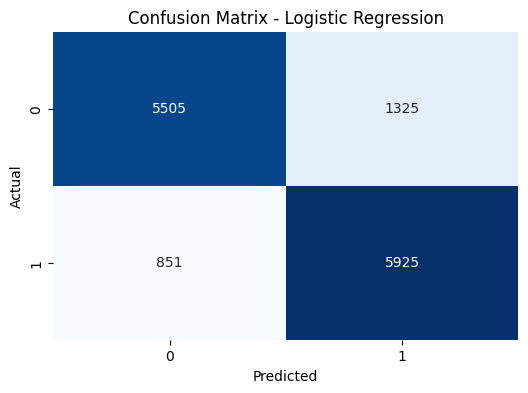


Logistic Regression Metrics:
Accuracy Score: 0.840
Error / Misclassification Rate: 0.160
Sensitivity / True Positive Rate / Recall: 0.874
False Positive Rate: 0.194
True Negative Rate / Specificity: 0.806
Precision: 0.817
F1 Score: 0.845
Log Loss: 0.338
Area under the ROC Curve: 0.927

Model Comparison:
                                           Logistic Regression  Random Forest
Accuracy Score                                        0.840071       0.882184
Error / Misclassification Rate                        0.159929       0.117816
Sensitivity / True Positive Rate / Recall             0.874410       0.896547
False Positive Rate                                   0.193997       0.132064
True Negative Rate / Specificity                      0.806003       0.867936
Precision                                             0.817241       0.870718
F1 Score                                              0.844860       0.883444
Log Loss                                              0.337553       0

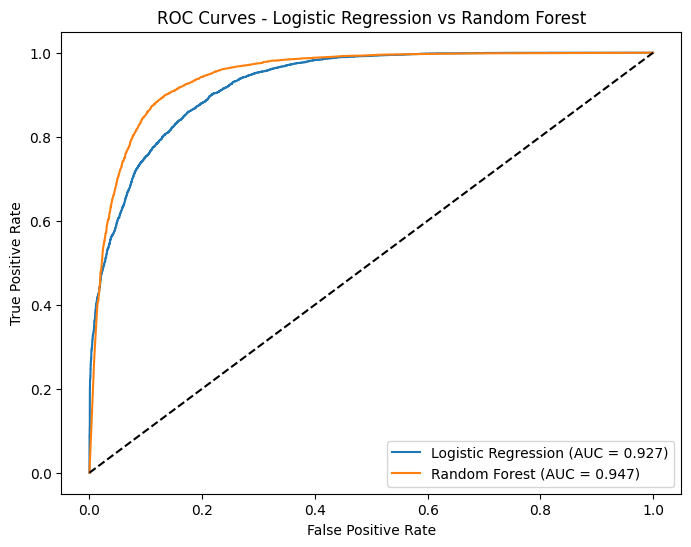

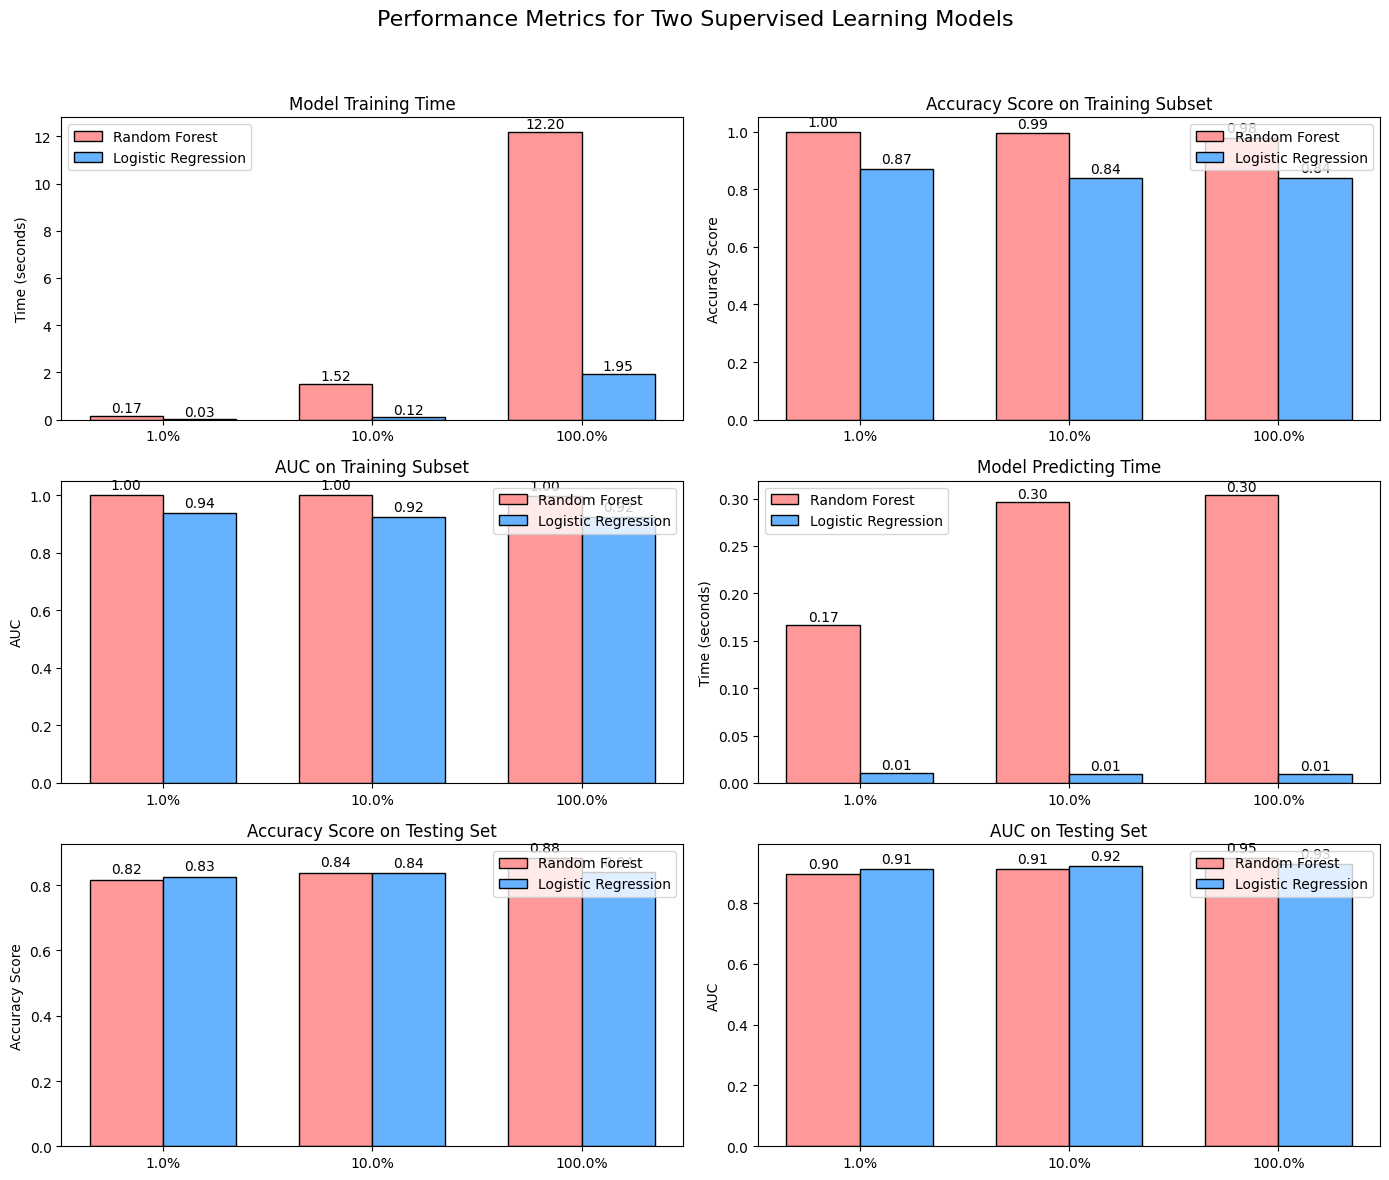

In [246]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, power_transform
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Step 4: Both Models Comparison and Evaluation with Fixed Performance Graph
print("Step 4: Both Models Comparison and Evaluation with Fixed Performance Graph")
# Load dataset
file_path = r"C:\Users\MSI\OneDrive\1. BiG_dAtA_Master_Degree\thesis\Code\Data\Classification\census.csv"
df_charity = pd.read_csv(file_path)

# Convert target to binary and validate
df_charity['income'] = df_charity['income'].str.strip()
unique_values = df_charity['income'].unique()
print("\nUnique values in 'income' before conversion:", unique_values)
df_charity['income'] = df_charity['income'].map({'>50K': 1, '<=50K': 0})
if df_charity['income'].isnull().any():
    raise ValueError("NaN values found in 'income' after mapping. Check for unexpected labels: " + str(unique_values))
print("\nIncome Distribution (After Conversion):")
print(df_charity['income'].value_counts(normalize=True))
if not set(df_charity['income'].unique()).issubset({0, 1}):
    raise ValueError("Conversion of 'income' to binary failed. Found values: " + str(df_charity['income'].unique()))

# Define columns and select data
numerical_cols = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_cols = ['workclass', 'education_level', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
target_col = 'income'
df_selected = df_charity[numerical_cols + categorical_cols + [target_col]].copy()

# Apply transformations only to numerical features, not target
df_selected['capital-gain-zero'] = (df_selected['capital-gain'] == 0).astype(int)
df_selected['capital-loss-zero'] = (df_selected['capital-loss'] == 0).astype(int)
df_transformed = df_selected[numerical_cols].copy()
for col in ['capital-gain', 'capital-loss']:
    non_zero_mask = df_transformed[col] > 0
    percentile_98 = df_transformed.loc[non_zero_mask, col].quantile(0.98)
    df_transformed.loc[non_zero_mask, col] = np.where(df_transformed.loc[non_zero_mask, col] > percentile_98, percentile_98, df_transformed.loc[non_zero_mask, col])
    df_transformed[col] = df_transformed[col].replace(0, np.nan)
    non_zero_mask = df_transformed[col].notna()
    non_zero_values = df_transformed.loc[non_zero_mask, col].values.reshape(-1, 1)
    transformed_values = power_transform(non_zero_values, method='yeo-johnson', standardize=False)
    df_transformed.loc[non_zero_mask, col] = transformed_values.flatten()
other_cols = ['age', 'education-num', 'hours-per-week']
df_transformed[other_cols] = power_transform(df_transformed[other_cols], method='yeo-johnson', standardize=False)
for col in ['capital-gain', 'capital-loss']:
    mean_non_zero = df_transformed.loc[df_transformed[col].notna(), col].mean()
    df_transformed[col] = df_transformed[col].fillna(mean_non_zero)
scaler = StandardScaler()
df_transformed[numerical_cols] = scaler.fit_transform(df_transformed[numerical_cols])
df_selected[numerical_cols] = df_transformed[numerical_cols]

# Encode categorical variables
df_encoded = pd.get_dummies(df_selected.drop(target_col, axis=1), columns=categorical_cols, drop_first=True)
y = df_selected[target_col].values  # Keep y as binary

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(df_encoded, y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Verify that y_train and y_test are numeric and binary
print("\nUnique values in y_train:", set(y_train))
print("Unique values in y_test:", set(y_test))
if not (set(y_train).issubset({0, 1}) and set(y_test).issubset({0, 1})):
    raise ValueError("y_train or y_test contains non-binary values. Found: " + str(set(y_train)) + ", " + str(set(y_test)))

# Step 4.1: Train and Evaluate Random Forest
print("\nRandom Forest Results:")
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# Verify predictions are numeric
print("Unique values in y_pred_rf:", set(y_pred_rf))
if not set(y_pred_rf).issubset({0, 1}):
    raise ValueError("y_pred_rf contains non-binary values: " + str(set(y_pred_rf)))

# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix_rf.png')
plt.show()

# Metrics for Random Forest
tn_rf, fp_rf, fn_rf, tp_rf = cm_rf.ravel()
rf_metrics = {
    'Accuracy Score': accuracy_score(y_test, y_pred_rf),
    'Error / Misclassification Rate': 1 - accuracy_score(y_test, y_pred_rf),
    'Sensitivity / True Positive Rate / Recall': recall_score(y_test, y_pred_rf),
    'False Positive Rate': fp_rf / (fp_rf + tn_rf) if (fp_rf + tn_rf) != 0 else 0,
    'True Negative Rate / Specificity': tn_rf / (tn_rf + fp_rf) if (tn_rf + fp_rf) != 0 else 0,
    'Precision': precision_score(y_test, y_pred_rf),
    'F1 Score': f1_score(y_test, y_pred_rf),
    'Log Loss': log_loss(y_test, y_prob_rf),
    'Area under the ROC Curve': roc_auc_score(y_test, y_prob_rf)
}
print("\nRandom Forest Metrics:")
for metric, value in rf_metrics.items():
    print(f"{metric}: {value:.3f}")

# Step 4.2: Train and Evaluate Logistic Regression
print("\nLogistic Regression Results:")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
y_prob_lr = lr_model.predict_proba(X_test)[:, 1]

# Verify predictions are numeric
print("Unique values in y_pred_lr:", set(y_pred_lr))
if not set(y_pred_lr).issubset({0, 1}):
    raise ValueError("y_pred_lr contains non-binary values: " + str(set(y_pred_lr)))

# Confusion Matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix_lr.png')
plt.show()

# Metrics for Logistic Regression
tn_lr, fp_lr, fn_lr, tp_lr = cm_lr.ravel()
lr_metrics = {
    'Accuracy Score': accuracy_score(y_test, y_pred_lr),
    'Error / Misclassification Rate': 1 - accuracy_score(y_test, y_pred_lr),
    'Sensitivity / True Positive Rate / Recall': recall_score(y_test, y_pred_lr),
    'False Positive Rate': fp_lr / (fp_lr + tn_lr) if (fp_lr + tn_lr) != 0 else 0,
    'True Negative Rate / Specificity': tn_lr / (tn_lr + fp_lr) if (tn_lr + fp_lr) != 0 else 0,
    'Precision': precision_score(y_test, y_pred_lr),
    'F1 Score': f1_score(y_test, y_pred_lr),
    'Log Loss': log_loss(y_test, y_prob_lr),
    'Area under the ROC Curve': roc_auc_score(y_test, y_prob_lr)
}
print("\nLogistic Regression Metrics:")
for metric, value in lr_metrics.items():
    print(f"{metric}: {value:.3f}")

# Step 4.3: Compare Models
print("\nModel Comparison:")
metrics_df = pd.DataFrame({'Logistic Regression': lr_metrics, 'Random Forest': rf_metrics})
print(metrics_df)

# Step 4.4: Plot ROC Curves for Both Models
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {lr_metrics["Area under the ROC Curve"]:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_metrics["Area under the ROC Curve"]:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Logistic Regression vs Random Forest')
plt.legend(loc='best')
plt.savefig('roc_curves_comparison.png')
plt.show()

# Step 4.5: Performance Metrics Graph for Different Training Sizes
train_sizes = [0.01, 0.1, 1.0]  # 1%, 10%, 100%
rf_train_times, rf_train_acc, rf_train_auc = [], [], []
rf_predict_times, rf_test_acc, rf_test_auc = [], [], []
lr_train_times, lr_train_acc, lr_train_auc = [], [], []
lr_predict_times, lr_test_acc, lr_test_auc = [], [], []

for size in train_sizes:
    n_samples = int(size * len(X_train))
    X_train_sub = X_train[:n_samples]
    y_train_sub = y_train[:n_samples]

    # Verify that y_train_sub is binary
    if not set(y_train_sub).issubset({0, 1}):
        raise ValueError(f"y_train_sub contains non-binary values for size {size}: {set(y_train_sub)}")

    # Random Forest
    start_time = time.time()
    rf_model.fit(X_train_sub, y_train_sub)
    rf_train_times.append(time.time() - start_time)

    start_time = time.time()
    y_pred_rf_sub = rf_model.predict(X_test)
    rf_predict_times.append(time.time() - start_time)
    rf_train_acc.append(accuracy_score(y_train_sub, rf_model.predict(X_train_sub)))
    rf_test_acc.append(accuracy_score(y_test, y_pred_rf_sub))
    rf_train_auc.append(roc_auc_score(y_train_sub, rf_model.predict_proba(X_train_sub)[:, 1]))
    rf_test_auc.append(roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]))

    # Verify that y_pred_rf_sub is binary
    if not set(y_pred_rf_sub).issubset({0, 1}):
        raise ValueError(f"y_pred_rf_sub contains non-binary values for size {size}: {set(y_pred_rf_sub)}")

    # Logistic Regression
    start_time = time.time()
    lr_model.fit(X_train_sub, y_train_sub)
    lr_train_times.append(time.time() - start_time)

    start_time = time.time()
    y_pred_lr_sub = lr_model.predict(X_test)
    lr_predict_times.append(time.time() - start_time)
    lr_train_acc.append(accuracy_score(y_train_sub, lr_model.predict(X_train_sub)))
    lr_test_acc.append(accuracy_score(y_test, y_pred_lr_sub))
    lr_train_auc.append(roc_auc_score(y_train_sub, lr_model.predict_proba(X_train_sub)[:, 1]))
    lr_test_auc.append(roc_auc_score(y_test, lr_model.predict_proba(X_test)[:, 1]))

    # Verify that y_pred_lr_sub is binary
    if not set(y_pred_lr_sub).issubset({0, 1}):
        raise ValueError(f"y_pred_lr_sub contains non-binary values for size {size}: {set(y_pred_lr_sub)}")

# Create subplots with improved visualization
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle('Performance Metrics for Two Supervised Learning Models', fontsize=16)

# Positions for bars (side by side)
x = np.arange(len(train_sizes))
width = 0.35

# Model Training Time
axes[0, 0].bar(x - width/2, rf_train_times, width, color='#FF9999', label='Random Forest', edgecolor='black')
axes[0, 0].bar(x + width/2, lr_train_times, width, color='#66B2FF', label='Logistic Regression', edgecolor='black')
for i, v in enumerate(rf_train_times):
    axes[0, 0].text(i - width/2, v + 0.01, f'{v:.2f}', ha='center', va='bottom')
for i, v in enumerate(lr_train_times):
    axes[0, 0].text(i + width/2, v + 0.01, f'{v:.2f}', ha='center', va='bottom')
axes[0, 0].set_title('Model Training Time', fontsize=12)
axes[0, 0].set_ylabel('Time (seconds)', fontsize=10)
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels([f'{s*100}%' for s in train_sizes])
axes[0, 0].legend()

# Accuracy Score on Training Subset
axes[0, 1].bar(x - width/2, rf_train_acc, width, color='#FF9999', label='Random Forest', edgecolor='black')
axes[0, 1].bar(x + width/2, lr_train_acc, width, color='#66B2FF', label='Logistic Regression', edgecolor='black')
for i, v in enumerate(rf_train_acc):
    axes[0, 1].text(i - width/2, v + 0.01, f'{v:.2f}', ha='center', va='bottom')
for i, v in enumerate(lr_train_acc):
    axes[0, 1].text(i + width/2, v + 0.01, f'{v:.2f}', ha='center', va='bottom')
axes[0, 1].set_title('Accuracy Score on Training Subset', fontsize=12)
axes[0, 1].set_ylabel('Accuracy Score', fontsize=10)
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels([f'{s*100}%' for s in train_sizes])
axes[0, 1].legend()

# AUC on Training Subset
axes[1, 0].bar(x - width/2, rf_train_auc, width, color='#FF9999', label='Random Forest', edgecolor='black')
axes[1, 0].bar(x + width/2, lr_train_auc, width, color='#66B2FF', label='Logistic Regression', edgecolor='black')
for i, v in enumerate(rf_train_auc):
    axes[1, 0].text(i - width/2, v + 0.01, f'{v:.2f}', ha='center', va='bottom')
for i, v in enumerate(lr_train_auc):
    axes[1, 0].text(i + width/2, v + 0.01, f'{v:.2f}', ha='center', va='bottom')
axes[1, 0].set_title('AUC on Training Subset', fontsize=12)
axes[1, 0].set_ylabel('AUC', fontsize=10)
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels([f'{s*100}%' for s in train_sizes])
axes[1, 0].legend()

# Model Predicting Time
axes[1, 1].bar(x - width/2, rf_predict_times, width, color='#FF9999', label='Random Forest', edgecolor='black')
axes[1, 1].bar(x + width/2, lr_predict_times, width, color='#66B2FF', label='Logistic Regression', edgecolor='black')
for i, v in enumerate(rf_predict_times):
    axes[1, 1].text(i - width/2, v + 0.001, f'{v:.2f}', ha='center', va='bottom')
for i, v in enumerate(lr_predict_times):
    axes[1, 1].text(i + width/2, v + 0.001, f'{v:.2f}', ha='center', va='bottom')
axes[1, 1].set_title('Model Predicting Time', fontsize=12)
axes[1, 1].set_ylabel('Time (seconds)', fontsize=10)
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels([f'{s*100}%' for s in train_sizes])
axes[1, 1].legend()

# Accuracy Score on Testing Set
axes[2, 0].bar(x - width/2, rf_test_acc, width, color='#FF9999', label='Random Forest', edgecolor='black')
axes[2, 0].bar(x + width/2, lr_test_acc, width, color='#66B2FF', label='Logistic Regression', edgecolor='black')
for i, v in enumerate(rf_test_acc):
    axes[2, 0].text(i - width/2, v + 0.01, f'{v:.2f}', ha='center', va='bottom')
for i, v in enumerate(lr_test_acc):
    axes[2, 0].text(i + width/2, v + 0.01, f'{v:.2f}', ha='center', va='bottom')
axes[2, 0].set_title('Accuracy Score on Testing Set', fontsize=12)
axes[2, 0].set_ylabel('Accuracy Score', fontsize=10)
axes[2, 0].set_xticks(x)
axes[2, 0].set_xticklabels([f'{s*100}%' for s in train_sizes])
axes[2, 0].legend()

# AUC on Testing Set
axes[2, 1].bar(x - width/2, rf_test_auc, width, color='#FF9999', label='Random Forest', edgecolor='black')
axes[2, 1].bar(x + width/2, lr_test_auc, width, color='#66B2FF', label='Logistic Regression', edgecolor='black')
for i, v in enumerate(rf_test_auc):
    axes[2, 1].text(i - width/2, v + 0.01, f'{v:.2f}', ha='center', va='bottom')
for i, v in enumerate(lr_test_auc):
    axes[2, 1].text(i + width/2, v + 0.01, f'{v:.2f}', ha='center', va='bottom')
axes[2, 1].set_title('AUC on Testing Set', fontsize=12)
axes[2, 1].set_ylabel('AUC', fontsize=10)
axes[2, 1].set_xticks(x)
axes[2, 1].set_xticklabels([f'{s*100}%' for s in train_sizes])
axes[2, 1].legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('performance_metrics_comparison_improved.png')
plt.show()